In [ ]:
!unzip "drive/MyDrive/SoML/data.zip" -d "drive/MyDrive/SoML/"

In [1]:
string_to_label = {'prefix': 0, 'infix': 1, 'postfix': 2}

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from torchvision import transforms, utils
from numpy.random import RandomState

In [28]:
data = pd.read_csv('SoML-50/annotations.csv')

rng = RandomState()
train_data = data.sample(frac = 0.8, random_state = rng)
test_data = data.loc[~data.index.isin(train_data.index)]

In [29]:
data['Value'].describe()

count    50000.00000
mean         8.98514
std         14.07956
min         -9.00000
25%          0.00000
50%          5.00000
75%         12.00000
max         81.00000
Name: Value, dtype: float64

In [ ]:
# X = np.ones((50000,1,128,384))
# y = np.ones((50000,2))
root = "drive/MyDrive/SoML/data/"
for index, row in data.iterrows():
  path = os.path.join(root, row['Image'])
  image = io.imread(path)
  if index%100 == 0:
    print(index)
  # X[index,0,:,:] = image
  # y[index] = [row['Label'], row['Value']]

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))])

In [4]:
class ExpressionDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.expression_frame = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.expression_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.expression_frame.iloc[idx, 0])
        image = io.imread(img_name)
        label = string_to_label[self.expression_frame.iloc[idx, 1]]
        value = self.expression_frame.iloc[idx, 2]
        if self.transform:
          image = self.transform(image)
        sample = (image, label, value)

        return sample

In [16]:
trainset = ExpressionDataset(csv_file = train_data, root_dir = "SoML-50/data/", transform = transforms.functional.to_tensor)
testset = ExpressionDataset(csv_file = test_data, root_dir = "SoML-50/data/", transform = transforms.functional.to_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [6]:
dataiter = iter(trainloader)
images, labels, values = dataiter.next()
print(images.shape)
print(labels.shape)
print(values.shape)

torch.Size([64, 1, 128, 384])
torch.Size([64])
torch.Size([64])


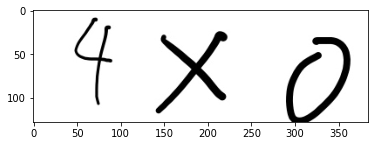

In [7]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray')

In [8]:
class ExpressionClassifier(nn.Module):   
  def __init__(self):
    super(ExpressionClassifier, self).__init__()
    self.cnn_layers = nn.Sequential(
      # (64,1,128,384) => (64,4,64,192)
      nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(4),
      nn.ReLU(inplace=True),
      # (64,4,64,192) => (64,4,31,95)
      nn.MaxPool2d(kernel_size=2, stride=2),
      # (64,4,31,95) => (64,4,15,47)
      nn.Conv2d(4, 4, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(4),
      nn.ReLU(inplace=True),
      # (64,4,15,47) => (64,4,6,22)
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.linear_layers = nn.Sequential(
      nn.Linear(768, 3)
    )
  # Defining the forward pass    
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [9]:
expression_model = ExpressionClassifier()
optimizer = optim.Adam(expression_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
  expression_model = expression_model.cuda()
  criterion = criterion.cuda()
print(expression_model)

ExpressionClassifier(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=768, out_features=3, bias=True)
  )
)


In [ ]:
EPOCHS = 10
for i in range(EPOCHS):
  running_loss = 0
  for images, labels, values in trainloader:
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    optimizer.zero_grad()
    output = expression_model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels, values = data
        outputs = expression_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 99 %


In [11]:
def infer_labels(images):
  outputs = expression_model(images)
  _, predicted = torch.max(outputs.data, 1)
  return predicted

In [41]:
class ValuePredictor(nn.Module):   
  def __init__(self):
    super(ValuePredictor, self).__init__()
    self.cnn_layers_digit = nn.Sequential(
        # (64,1,128,384) => (64,4,64,192)
        nn.Conv2d(1, 4, kernel_size=3, stride=4, padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        # (64,4,64,192) => (64,4,31,95)
        nn.MaxPool2d(kernel_size=2, stride=2),
        # (64,4,31,95) => (64,4,15,47)
        nn.Conv2d(4, 4, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        # # (64,4,15,47) => (64,4,6,22)
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.linear_layers_digit = nn.Sequential(
        nn.Linear(64, 10)
    )
    self.cnn_layers_operator = nn.Sequential(
        # (64,1,128,384) => (64,4,64,192)
        nn.Conv2d(1, 4, kernel_size=3, stride=4, padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        # (64,4,64,192) => (64,4,31,95)
        nn.MaxPool2d(kernel_size=2, stride=2),
        # (64,4,31,95) => (64,4,15,47)
        nn.Conv2d(4, 4, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(4),
        nn.ReLU(inplace=True),
        # # (64,4,15,47) => (64,4,6,22)
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.linear_layers_operator = nn.Sequential(
        nn.Linear(64, 4)
    )
    self.linear_layers_final = nn.Sequential(
        nn.Linear(24, 91)
    )
  # Defining the forward pass    
  def forward(self, x):
    labels = infer_labels(x)
    for i, label in enumerate(labels):
      if label == 0:
        operator = x[:,:,:,:128]
        digit1 = x[:,:,:,128:256]
        digit2 = x[:,:,:,256:]
      elif label == 1:
        digit1 = x[:,:,:,:128]
        operator = x[:,:,:,128:256]
        digit2 = x[:,:,:,256:]
      else :
        digit1 = x[:,:,:,:128]
        digit2 = x[:,:,:,128:256]
        operator = x[:,:,:,256:]
    digit1 = self.cnn_layers_digit(digit1)
    digit1 = digit1.view(digit1.size(0), -1)
    digit1 = self.linear_layers_digit(digit1)
    digit2 = self.cnn_layers_digit(digit2)
    digit2 = digit2.view(digit2.size(0), -1)
    digit2 = self.linear_layers_digit(digit2)
    operator = self.cnn_layers_operator(operator)
    operator = operator.view(operator.size(0), -1)
    operator = self.linear_layers_operator(operator)
    output = torch.cat((digit1, digit2, operator), 1)
    output = self.linear_layers_final(output)
    return output

In [42]:
value_model = ValuePredictor()
optimizer = optim.Adam(value_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
  value_model = value_model.cuda()
  criterion = criterion.cuda()
print(value_model)

ValuePredictor(
  (cnn_layers_digit): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers_digit): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
  )
  (cnn_layers_operator): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [43]:
EPOCHS = 10
for i in range(EPOCHS):
  running_loss = 0
  count = 0
  for images, labels, values in trainloader:
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
      values = values.cuda()
    optimizer.zero_grad()
    output = value_model(images)
    # print(torch.squeeze(torch.add(values,9)))
    loss = criterion(output, torch.squeeze(torch.add(values,9)))
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    count += 64
    print("Data Processed: ", count/400, "%")
  print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))
  torch.save(value_model.state_dict(), 'value_model.pth')

Data Processed:  0.16 %
Data Processed:  0.32 %
Data Processed:  0.48 %
Data Processed:  0.64 %
Data Processed:  0.8 %
Data Processed:  0.96 %
Data Processed:  1.12 %
Data Processed:  1.28 %
Data Processed:  1.44 %
Data Processed:  1.6 %
Data Processed:  1.76 %
Data Processed:  1.92 %
Data Processed:  2.08 %
Data Processed:  2.24 %
Data Processed:  2.4 %
Data Processed:  2.56 %
Data Processed:  2.72 %
Data Processed:  2.88 %
Data Processed:  3.04 %
Data Processed:  3.2 %
Data Processed:  3.36 %
Data Processed:  3.52 %
Data Processed:  3.68 %
Data Processed:  3.84 %
Data Processed:  4.0 %
Data Processed:  4.16 %
Data Processed:  4.32 %
Data Processed:  4.48 %
Data Processed:  4.64 %
Data Processed:  4.8 %
Data Processed:  4.96 %
Data Processed:  5.12 %
Data Processed:  5.28 %
Data Processed:  5.44 %
Data Processed:  5.6 %
Data Processed:  5.76 %
Data Processed:  5.92 %
Data Processed:  6.08 %
Data Processed:  6.24 %
Data Processed:  6.4 %
Data Processed:  6.56 %
Data Processed:  6.72 %


In [45]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels, values = data
        outputs = value_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.squeeze(torch.add(values,9))).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 13 %


**Saving and Loading Model**

In [ ]:
torch.save(expression_model.state_dict(), 'model.pth')

In [14]:
expression_model = ExpressionClassifier()
expression_model.load_state_dict(torch.load('model.pth'))
expression_model.eval()
if torch.cuda.is_available():
  expression_model.cuda()

value_model = ValuePredictor()
value_model.load_state_dict(torch.load('value_model.pth'))
value_model.eval()
if torch.cuda.is_available():
  value_model.cuda()

In [ ]:
!ls drive/MyDrive/SoML/data | wc -l

In [18]:
torch.save(value_model.state_dict(), 'value_model.pth')